In [1]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance
from scipy.stats import mannwhitneyu

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtrans

sns.set_theme(style='darkgrid')

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [338]:
import matplotlib.transforms as mtrans

In [2]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [3]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        num_docs = len(c.documents)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, POSITIONS_MAP[c.subject.position], num_docs)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position', 'num_docs'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [4]:
data_df = df.reset_index(drop=False)

data_df = data_df[data_df['position'] == 'Meteorologist']

data_df[data_df['type'].isin(['intra-subject'])]['num_docs'].sum()

496742

In [5]:
data_df = df.reset_index(drop=False)

data_df = data_df[data_df['position'] == 'Meteorologist']

data_df[data_df['type'] == 'intra-subject-consistency']['num_docs'].sum()

496742

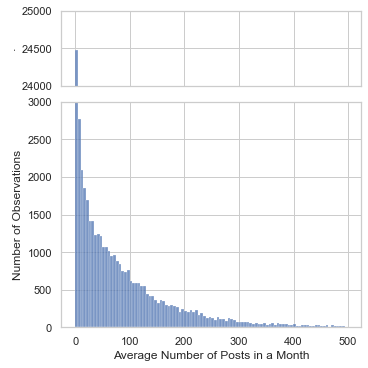

In [109]:
sns.set_theme(style='whitegrid')

num_docs_s = df.reset_index(drop=False).num_docs

num_docs_s = num_docs_s[num_docs_s < 500]

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(5, 5), sharex=True, constrained_layout=True,
                            gridspec_kw={'height_ratios': [2, 6]})

# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)

sns.histplot(num_docs_s, bins=100, ax=ax1)
ax1.set_ylim(24000, 25000)
ax1.set_ylabel(ylabel='.')

sns.histplot(num_docs_s, bins=100, ax=ax2)
ax2.set_ylim(0, 3000)
ax2.set_xlabel(xlabel='Average Number of Posts in a Month')
ax2.set_ylabel(ylabel='Number of Observations')

fig.tight_layout()
plt.show()

In [111]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

In [113]:
df[index_filter(df, type='intra-subject')]

,,,,,,,,,Topic 1 - Emissions/Gas,Topic 2 - Energy/Cliamate/Oil/Gas,Topic 3 - Forecast,Topic 4 - Forecast,Topic 5 - Forecast/Strom,Topic 6 - Gas/Extreme
id,type,group,index,subject_id,event_id,event_type,position,num_docs,,,,,,
2494,intra-subject,Before,0,106299641910,115881228731,Joined,Meteorologist,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2495,intra-subject,After,0,106299641910,115881228731,Joined,Meteorologist,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2496,intra-subject,Before,0,2067040562,327590147888,Joined,Meteorologist,1392,0.196057,0.102466,0.129105,0.127932,0.097098,0.347342
2497,intra-subject,After,0,2067040562,327590147888,Joined,Meteorologist,1320,0.127702,0.117059,0.277148,0.169103,0.079262,0.229727
2498,intra-subject,Before,0,387950156117,521514204626,Joined,Meteorologist,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5059,intra-subject,After,0,681439837846,812321945858,Workshop,Reporter,4015,0.105889,0.519913,0.000000,0.000000,0.075100,0.299090
5060,intra-subject,Before,0,850882780886,812321945858,Workshop,Reporter,550,0.045559,0.274492,0.278124,0.185131,0.043618,0.173076
5061,intra-subject,After,0,850882780886,812321945858,Workshop,Reporter,419,0.184928,0.520570,0.000000,0.027170,0.000000,0.253898


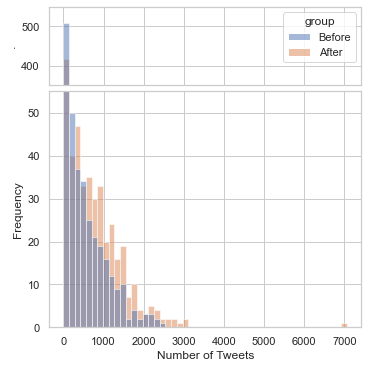

In [140]:
sns.set_theme(style='whitegrid')

data_df = df[index_filter(df, type='intra-subject')] \
        .reset_index(drop=False)

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

fig_df = data_df[['num_docs', 'group']]

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(5, 5), sharex=True, constrained_layout=True,
                            gridspec_kw={'height_ratios': [2, 6]})

# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)

sns.histplot(fig_df, x='num_docs', hue='group', bins=50, ax=ax1)
ax1.set_ylim(350, 550)
ax1.set_ylabel(ylabel='.')

sns.histplot(fig_df, x='num_docs', hue='group', bins=50, ax=ax2)
ax2.get_legend().remove()
ax2.set_ylim(0, 55)
ax2.set_xlabel(xlabel='Number of Tweets')
ax2.set_ylabel(ylabel='Frequency')

fig.tight_layout()
plt.show()

In [144]:
df[index_filter(df, type='intra-subject-consistency')]

,,,,,,,,,Topic 1 - Emissions/Gas,Topic 2 - Energy/Cliamate/Oil/Gas,Topic 3 - Forecast,Topic 4 - Forecast,Topic 5 - Forecast/Strom,Topic 6 - Gas/Extreme
id,type,group,index,subject_id,event_id,event_type,position,num_docs,,,,,,
5064,intra-subject-consistency,Before,1,106299641910,115881228731,Joined,Meteorologist,0,0.0,0.0,0.0,0.0,0.0,0.0
5065,intra-subject-consistency,Before,2,106299641910,115881228731,Joined,Meteorologist,0,0.0,0.0,0.0,0.0,0.0,0.0
5066,intra-subject-consistency,Before,3,106299641910,115881228731,Joined,Meteorologist,0,0.0,0.0,0.0,0.0,0.0,0.0
5067,intra-subject-consistency,Before,4,106299641910,115881228731,Joined,Meteorologist,0,0.0,0.0,0.0,0.0,0.0,0.0
5068,intra-subject-consistency,Before,5,106299641910,115881228731,Joined,Meteorologist,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33307,intra-subject-consistency,After,7,1006028491841,812321945858,Workshop,Other,0,0.0,0.0,0.0,0.0,0.0,0.0
33308,intra-subject-consistency,After,8,1006028491841,812321945858,Workshop,Other,0,0.0,0.0,0.0,0.0,0.0,0.0
33309,intra-subject-consistency,After,9,1006028491841,812321945858,Workshop,Other,0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


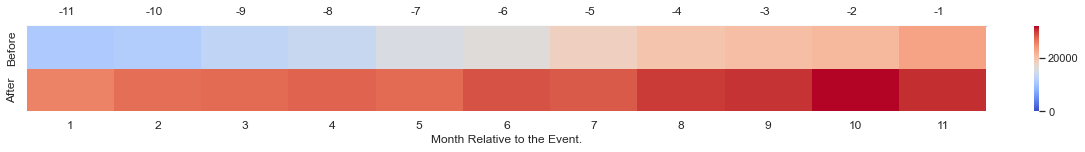

In [349]:
sns.set_theme(style='whitegrid')

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .reset_index(drop=False)

data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))
data_df = data_df[data_df['Position'] == 'Meteorologist']

data_df = data_df.pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'Position'], 
            columns=['index'], 
            values='num_docs',
        ) \
        .dropna()

df_data = pd.DataFrame({
    'Before': data_df[index_filter(data_df, group='Before')].sum(),
    'After': data_df[index_filter(data_df, group='After')].sum(),
}).T

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 2), sharex=True, constrained_layout=True)

colormap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_data, ax=ax, cmap=colormap, vmin=0)
# ax.tick_params(top=False, labeltop=True)
ax.tick_params(axis='both', labelsize=12)

ax_top = ax.secondary_xaxis('top')
ax_top.tick_params(axis='x', labeltop=True, top=False)
ax_top.tick_params(axis='both', labelsize=12)
ax_top.set_xticks(np.arange(11), labels=range(-11, 0))
trans = mtrans.Affine2D().translate(40, 0)
for t in ax_top.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

ax.set_xlabel(xlabel='Month Relative to the Event.')

# plt.show()
plt.savefig('monthly-tweeting-behavior-of-subjects.eps', bbox_inches='tight', format='eps', dpi=300)

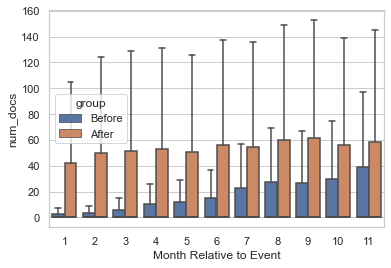

In [217]:
sns.set_theme(style='whitegrid')

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .reset_index(drop=False)

data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))
data_df = data_df[data_df['Position'] == 'Meteorologist']

data_df = data_df[['group', 'index', 'num_docs']]

ax = sns.boxplot(data=data_df, x='index', y='num_docs', hue='group', showfliers=False)

ax.set_xlabel(xlabel='Month Relative to Event')

plt.show()

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:xlabel='index'>

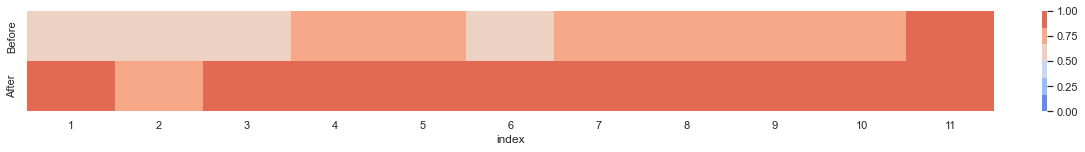

In [238]:
sns.set_theme(style='whitegrid')

relevant_topics_cols = ['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba')

data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))
data_df = data_df[data_df['Position'] == 'Meteorologist']

data_df = data_df.pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

df_data = pd.DataFrame({
    'Before': data_df[index_filter(data_df, group='Before')].mean(),
    'After': data_df[index_filter(data_df, group='After')].mean(),
}).T

# df_data = df_data / df_data.max().max()

# creating a colormap
colormap = sns.color_palette("coolwarm")

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 2), sharey=True, constrained_layout=True)

sns.heatmap(df_data, vmin=0, cmap=colormap, ax=ax)